In [1]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [2]:
LOWER = 1
UPPER = 11

# SST-2

In [3]:
train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
eval_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

In [4]:
train_df.set_axis(['text', 'label'], axis=1, inplace=True)
eval_df.set_axis(['text', 'label'], axis=1, inplace=True)

In [5]:
train_df

,text,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
...,...,...
6915,"painful , horrifying and oppressively tragic ,...",1
6916,take care is nicely performed by a quintet of ...,0
6917,"the script covers huge , heavy topics in a bla...",0
6918,a seriously bad film with seriously warped log...,0


In [6]:
eval_df

,text,label
0,"no movement , no yuks , not much of anything",0
1,"a gob of drivel so sickly sweet , even the eag...",0
2,"gangs of new york is an unapologetic mess , wh...",0
3,"we never really feel involved with the story ,...",0
4,this is one of polanski 's best films,1
...,...,...
1816,"an often deadly boring , strange reading of a ...",0
1817,the problem with concept films is that if the ...,0
1818,"safe conduct , however ambitious and well inte...",0
1819,"a film made with as little wit , interest , an...",0


In [7]:
def sentence_pairs_generation(sentences, labels, pairs, neg_lab=0.0):
    # initialize two empty lists to hold the (sentence, sentence) pairs and
    # labels to indicate if a pair is positive or negative

    numClassesList = np.unique(labels)
    idx = [np.where(labels == i)[0] for i in numClassesList]

    for idxA in range(len(sentences)):      
        currentSentence = sentences[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
        posSentence = sentences[idxB]
              # prepare a positive pair and update the sentences and labels
              # lists, respectively
        pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

        negIdx = np.where(labels != label)[0]
        negSentence = sentences[np.random.choice(negIdx)]
              # prepare a negative pair of images and update our lists
        pairs.append(InputExample(texts=[currentSentence, negSentence], label=neg_lab))

    # return a 2-tuple of our image pairs and labels
    return (pairs)

In [8]:
def SetFit(train_df, eval_df, epoch, neg_lab):
    set_seed(0)
    st_model = 'paraphrase-mpnet-base-v2' 
    num_training = 32 
    num_itr = 5 
    text_col=train_df.columns.values[0] 
    category_col=train_df.columns.values[1]
    x_eval = eval_df[text_col].values.tolist()
    y_eval = eval_df[category_col].values.tolist()
    
    examples = []
    for label in train_df['label'].unique():
        subset = train_df[train_df['label']==label]
        if len(subset) > num_training:
            examples.append(subset.sample(num_training))
        else:
            examples.append(subset)
    train_df_sample = pd.concat(examples)
    x_train = train_df_sample[text_col].values.tolist()
    y_train = train_df_sample[category_col].values.tolist()
    
    train_examples = [] 
    for x in range(num_itr):
        train_examples = sentence_pairs_generation(np.array(x_train), 
                                                   np.array(y_train), 
                                                   train_examples, 
                                                   neg_lab)


    model = SentenceTransformer(st_model)

    # S-BERT adaptation 
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
    train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=epoch, warmup_steps=10, show_progress_bar=False)
    
  
    print('train epochs: {}'.format(epoch))


    # With Fit (SetFit)
    X_train = model.encode(x_train)
    X_eval = model.encode(x_eval)

    sgd =  LogisticRegression()
    sgd.fit(X_train, y_train)
    y_pred_eval_sgd = sgd.predict(X_eval)
    
    acc = accuracy_score(y_eval, y_pred_eval_sgd)

    print('Acc. SetFit {}'.format(acc))
    
    plot_fit(y_eval, y_train, X_train, X_eval, epoch)
    
    return acc
    

In [9]:
def plot_fit(y_eval, y_train, X_train, X_eval, epoch):
    plt.figure(figsize=(12,10))

    #Plot X_train SetFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

    plt.subplot(221)
    plt.title('X_train SetFit: epochs = {}'.format(epoch))

    for i, t in enumerate(set(np.array(y_train))):
        idx = np.array(y_train) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

    #Plot X_eval SetFit
    X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval))
    plt.subplot(222)
    plt.title('X_eval SetFit: epochs = {}'.format(epoch))

    for i, t in enumerate(set(np.array(y_eval))):
        idx = np.array(y_eval) == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

# SST-2 negative label == 0

train epochs: 1
Acc. SetFit 0.8802855573860516
train epochs: 2
Acc. SetFit 0.9028006589785832
train epochs: 3
Acc. SetFit 0.9055464030752334
train epochs: 4
Acc. SetFit 0.900604063701263
train epochs: 5
Acc. SetFit 0.9017023613399231
train epochs: 6
Acc. SetFit 0.8989566172432729
train epochs: 7
Acc. SetFit 0.8984074684239429
train epochs: 8
Acc. SetFit 0.9093904448105437
train epochs: 9
Acc. SetFit 0.899505766062603
train epochs: 10
Acc. SetFit 0.9011532125205931


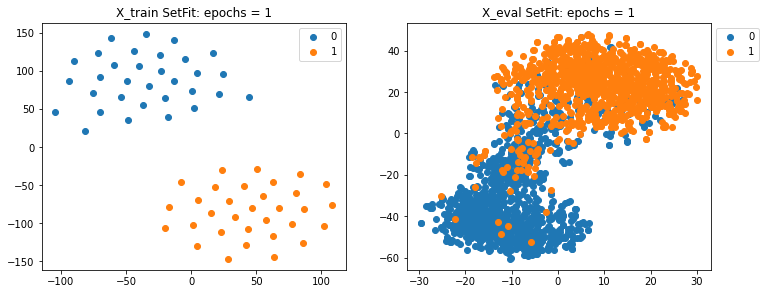

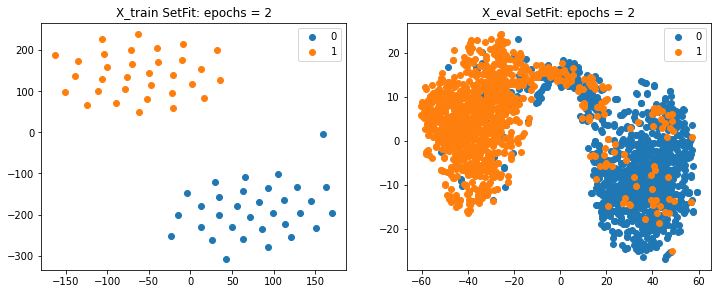

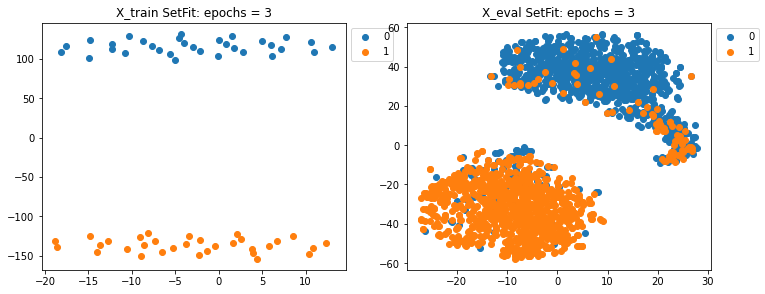

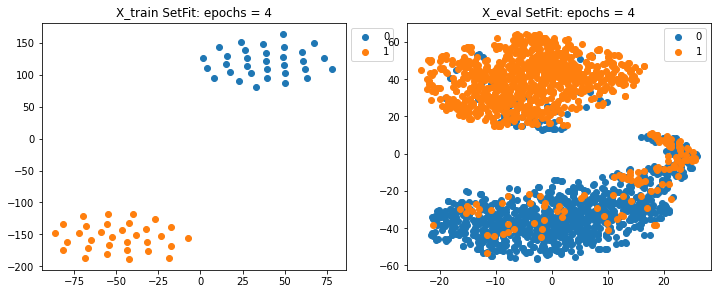

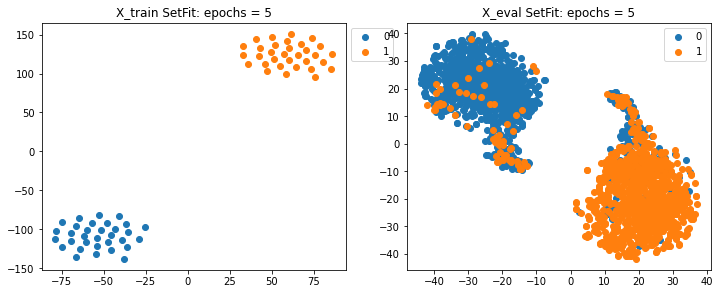

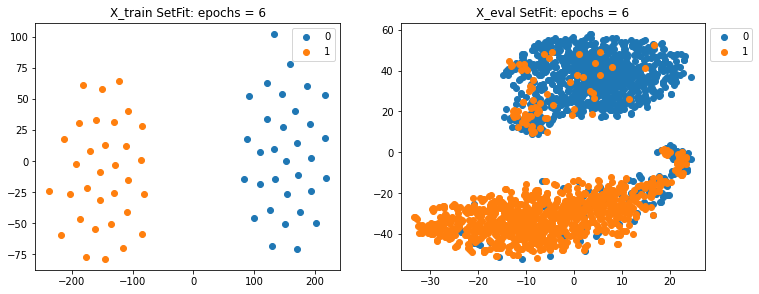

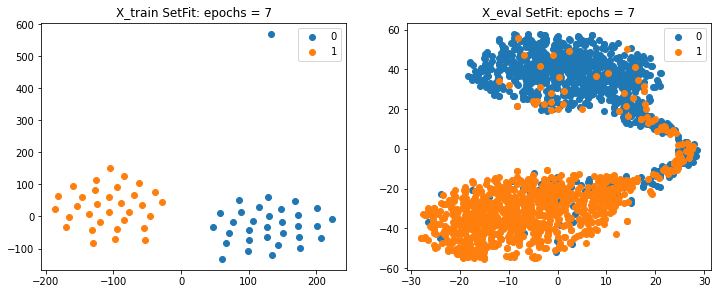

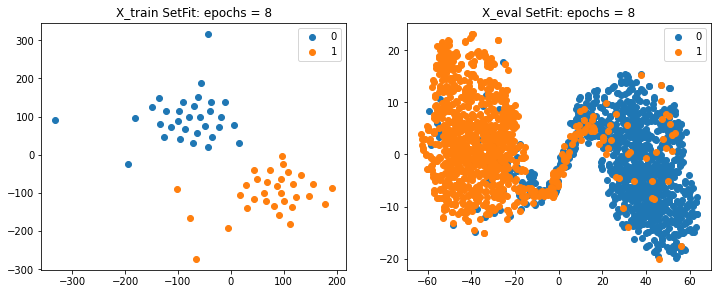

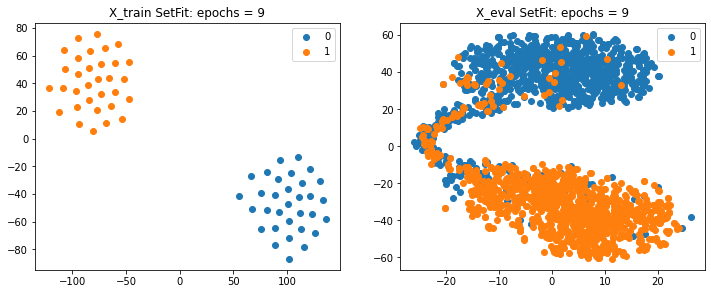

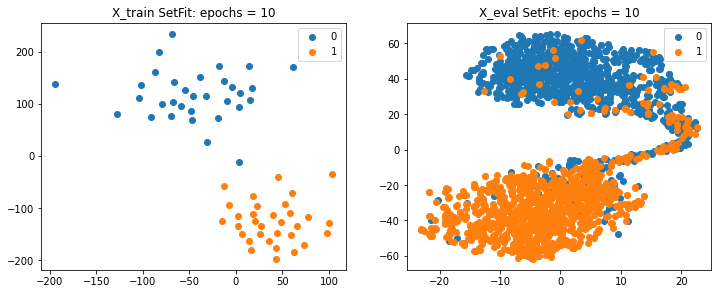

In [10]:
sst2_0_accs = []
for epoch in range(LOWER, UPPER):
    acc = SetFit(train_df, eval_df, epoch, neg_lab=0.0)
    sst2_0_accs.append(acc)

train epochs: 1
Acc. SetFit 0.8802855573860516
train epochs: 2
Acc. SetFit 0.9028006589785832
train epochs: 3
Acc. SetFit 0.9055464030752334

# SST-2 negative label == -1

train epochs: 1
Acc. SetFit 0.8912685337726524
train epochs: 2
Acc. SetFit 0.885227896760022
train epochs: 3
Acc. SetFit 0.8808347062053816
train epochs: 4
Acc. SetFit 0.8780889621087314
train epochs: 5
Acc. SetFit 0.8808347062053816
train epochs: 6
Acc. SetFit 0.885227896760022
train epochs: 7
Acc. SetFit 0.8841295991213619
train epochs: 8
Acc. SetFit 0.8797364085667215
train epochs: 9
Acc. SetFit 0.8802855573860516
train epochs: 10
Acc. SetFit 0.8802855573860516


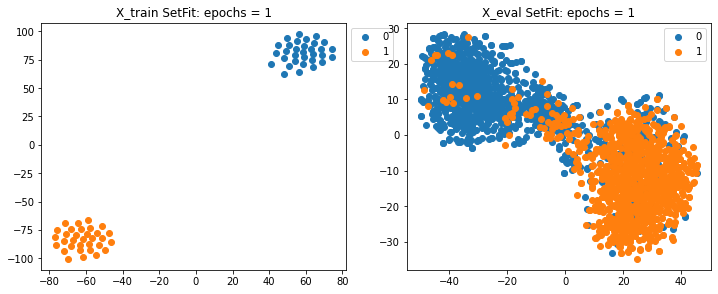

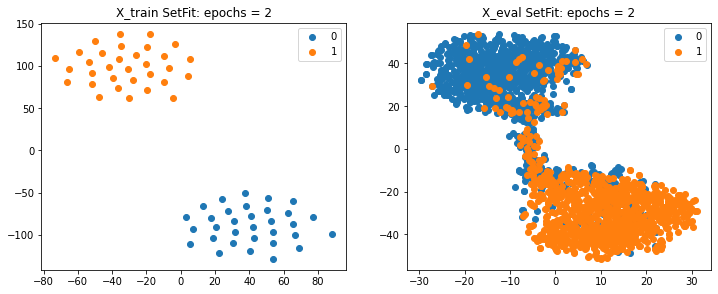

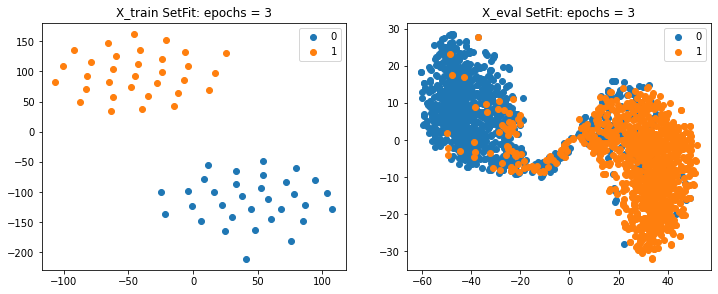

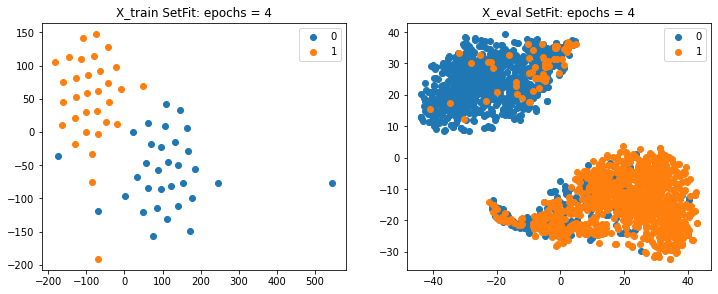

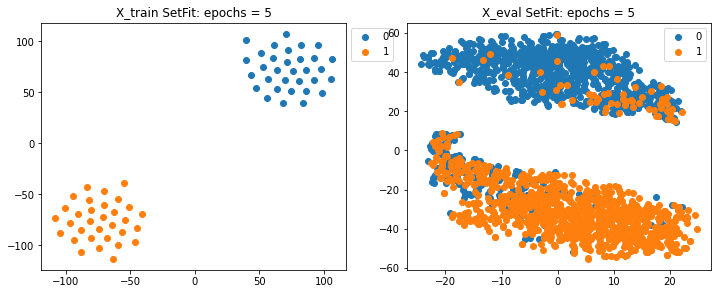

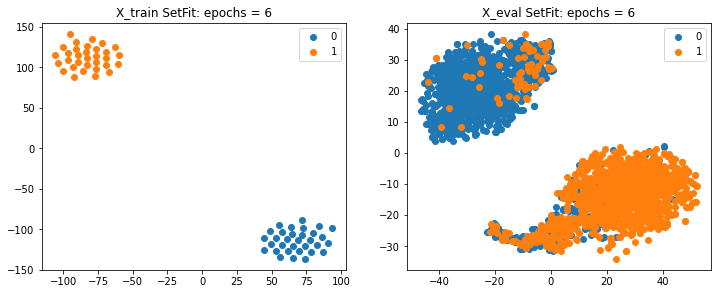

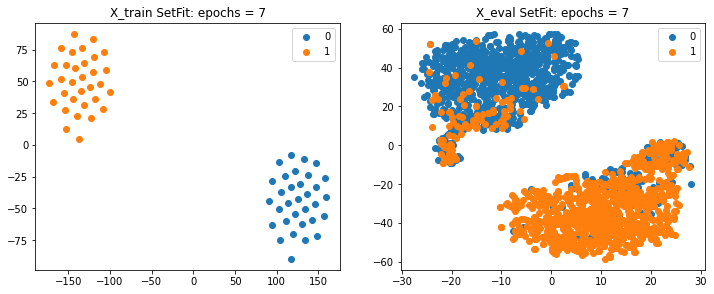

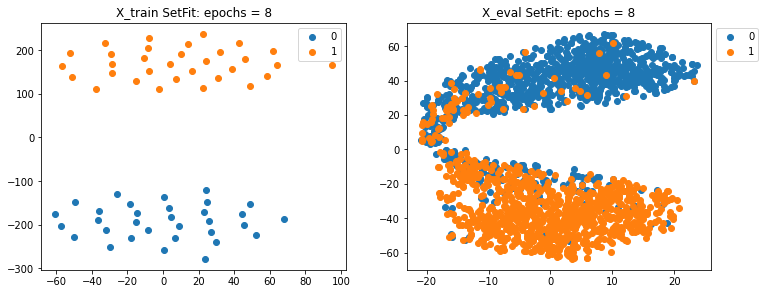

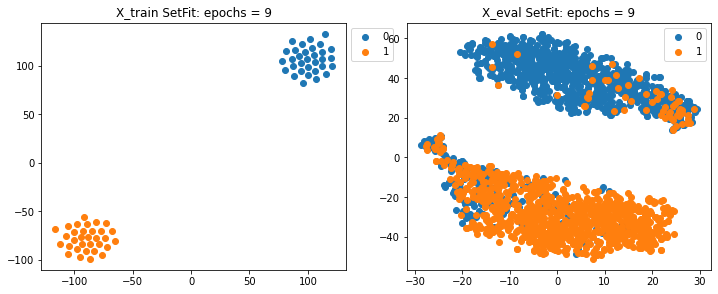

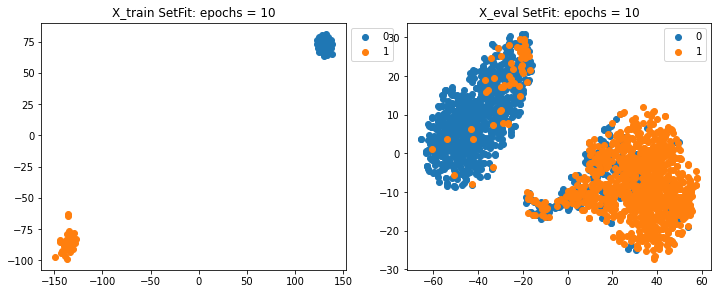

In [11]:
sst2_neg1_accs = []
for epoch in range(LOWER, UPPER):
    acc = SetFit(train_df, eval_df, epoch, neg_lab=-1.0)
    sst2_neg1_accs.append(acc)

# SST-5

In [12]:
def fix_df(df):
    labels, txt = [], []
    for text in df['text'].to_list():
        label = text[0]
        keep_text = text[1:]
        labels.append(int(label))
        txt.append(keep_text)
    return pd.DataFrame({'text': txt, 'label': labels})

In [13]:
#sst5 from here: https://github.com/toriving/text-classification-transformers/tree/master/data_in/sst5
names = ['text']
sst5_train = pd.read_csv('stsa_fine_train.txt',names=names, delimiter='\t', header=None)
sst5_dev = pd.read_csv('stsa_fine_dev.txt',names=names, delimiter='\t', header=None)

In [14]:
train_df = fix_df(sst5_train)
eval_df = fix_df(sst5_dev)

In [15]:
train_df

,text,label
0,"a stirring , funny and finally transporting r...",4
1,apparently reassembled from the cutting-room ...,1
2,they presume their audience wo n't sit still ...,1
3,the entire movie is filled with deja vu momen...,2
4,this is a visually stunning rumination on lov...,3
...,...,...
8539,take care is nicely performed by a quintet of...,1
8540,"the script covers huge , heavy topics in a bl...",1
8541,a seriously bad film with seriously warped lo...,1
8542,it 's not too racy and it 's not too offensive .,2


In [16]:
eval_df

,text,label
0,"in his first stab at the form , jacquot takes...",2
1,one long string of cliches .,1
2,if you 've ever entertained the notion of doi...,1
3,k-19 exploits our substantial collective fear...,0
4,it 's played in the most straight-faced fashi...,1
...,...,...
1096,`` the ring '' is pretty much an english-lang...,2
1097,"smart , provocative and blisteringly funny .",3
1098,"this one is definitely one to skip , even for...",0
1099,charles ' entertaining film chronicles seinfe...,3


# SST-5 negative label == 0

train epochs: 1


/home/bates/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acc. SetFit 0.47411444141689374
train epochs: 2
Acc. SetFit 0.47774750227066304
train epochs: 3
Acc. SetFit 0.4940962761126249
train epochs: 4
Acc. SetFit 0.4822888283378747
train epochs: 5
Acc. SetFit 0.4750227066303361
train epochs: 6
Acc. SetFit 0.4677565849227975
train epochs: 7
Acc. SetFit 0.4695731153496821
train epochs: 8
Acc. SetFit 0.47048138056312444
train epochs: 9
Acc. SetFit 0.47048138056312444
train epochs: 10
Acc. SetFit 0.47048138056312444


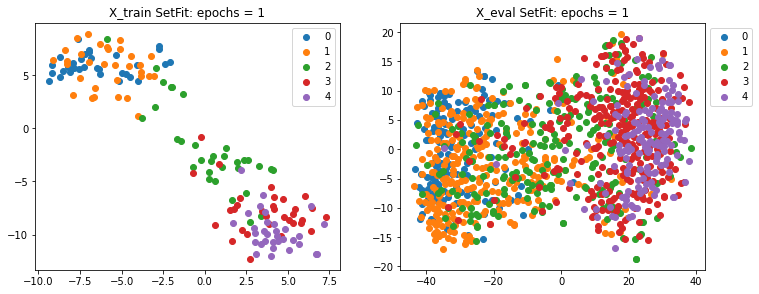

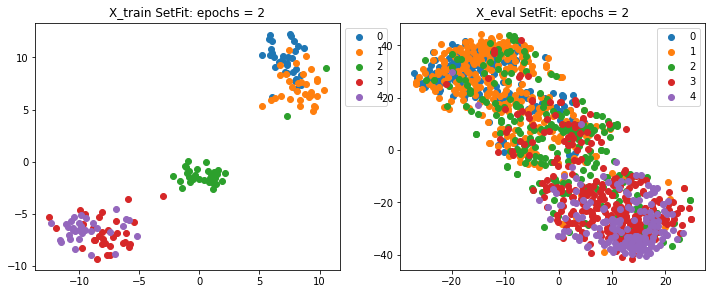

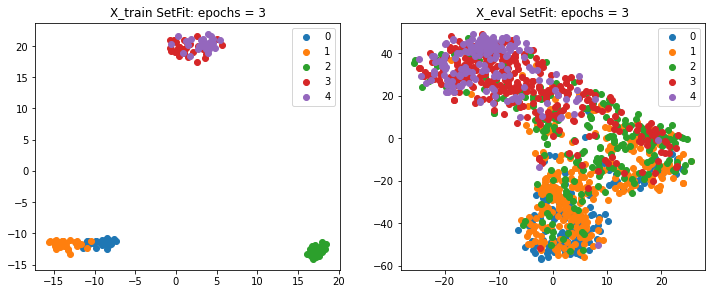

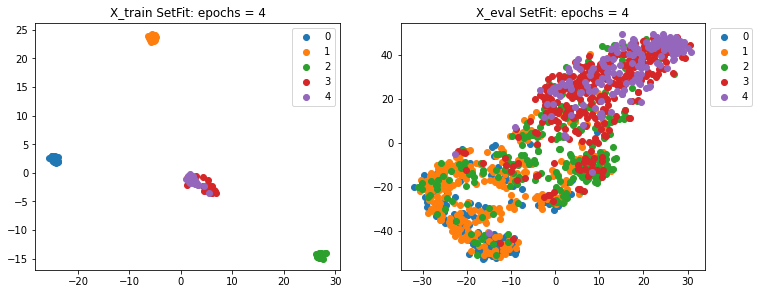

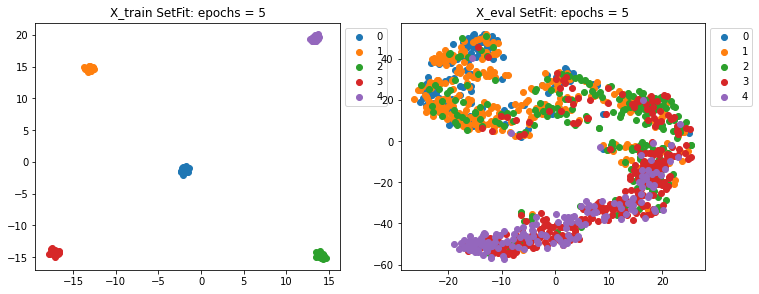

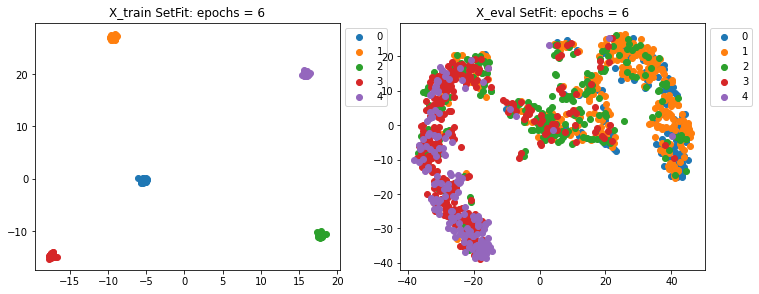

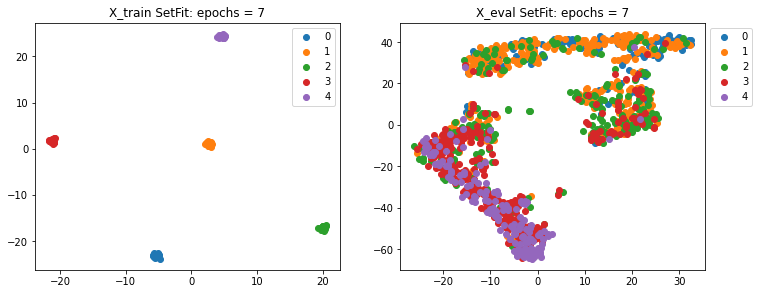

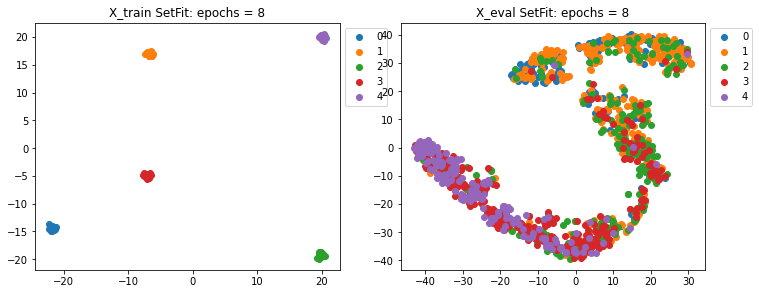

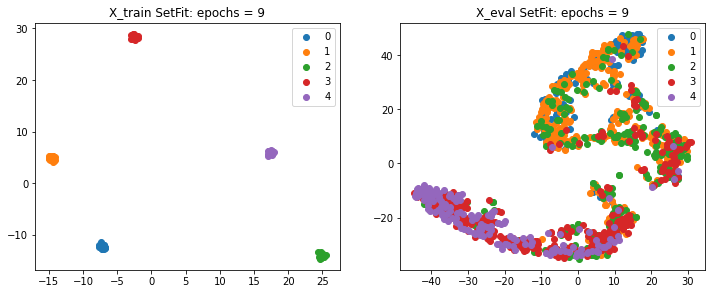

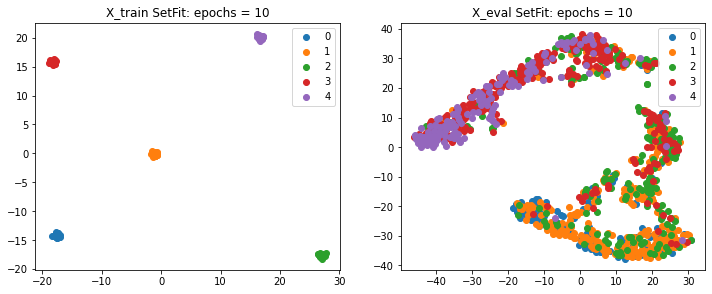

In [17]:
sst5_0_accs = []
for epoch in range(LOWER, UPPER):
    acc = SetFit(train_df, eval_df, epoch, neg_lab=0.0)
    sst5_0_accs.append(acc)

# SST-5 negative == -1

train epochs: 1
Acc. SetFit 0.46866485013623976
train epochs: 2
Acc. SetFit 0.4623069936421435
train epochs: 3
Acc. SetFit 0.4550408719346049
train epochs: 4
Acc. SetFit 0.45231607629427795
train epochs: 5
Acc. SetFit 0.45958219800181654
train epochs: 6
Acc. SetFit 0.45594913714804725
train epochs: 7
Acc. SetFit 0.4586739327883742
train epochs: 8
Acc. SetFit 0.46139872842870117
train epochs: 9
Acc. SetFit 0.4405086285195277
train epochs: 10
Acc. SetFit 0.44232515894641233


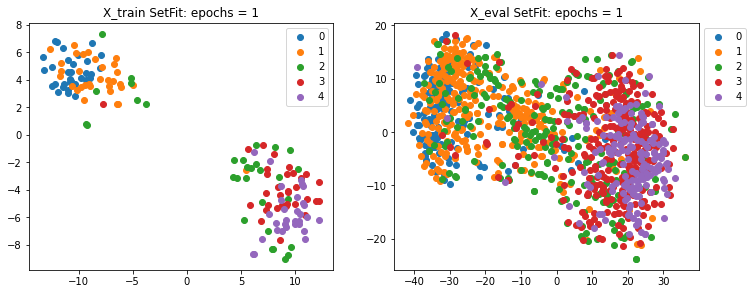

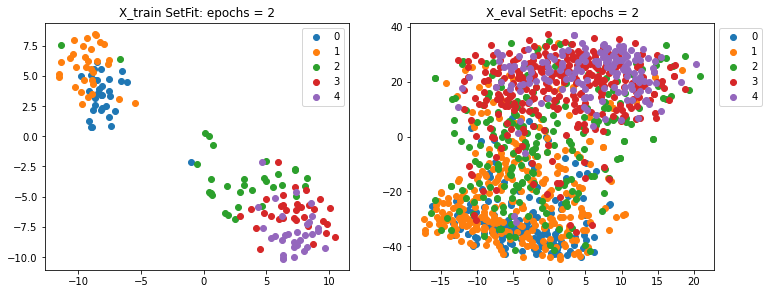

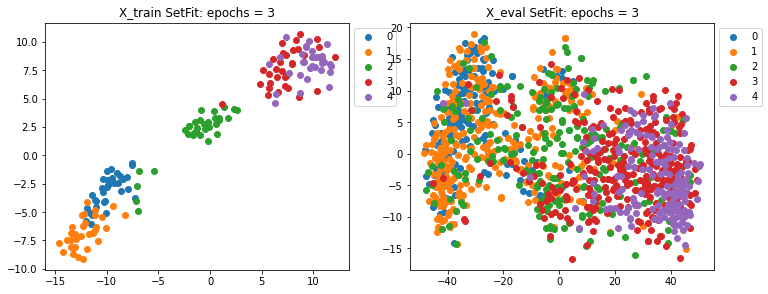

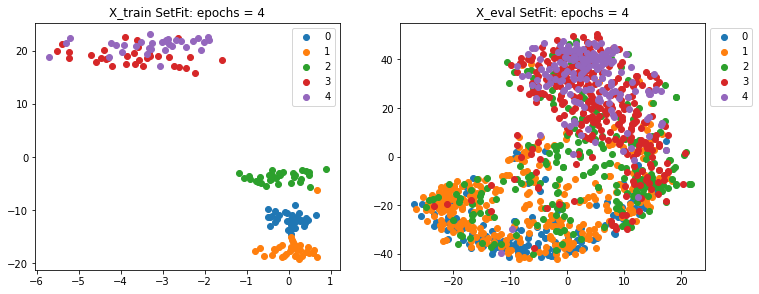

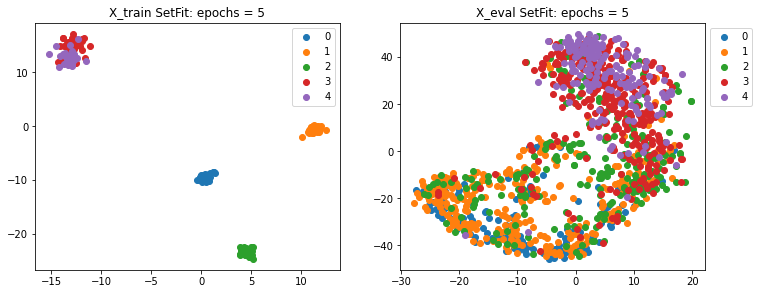

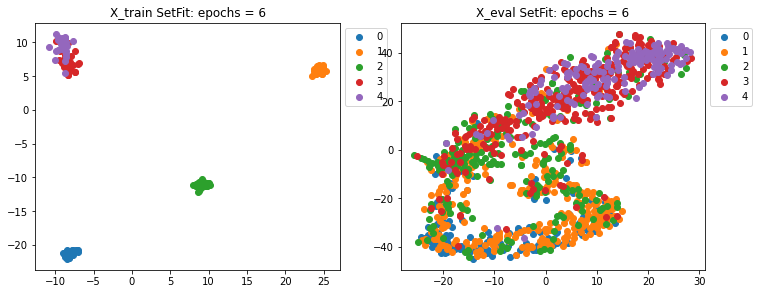

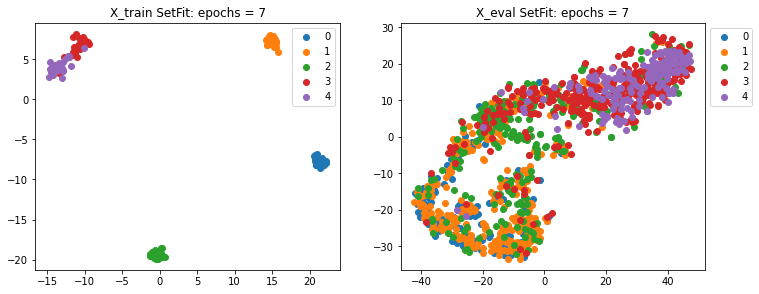

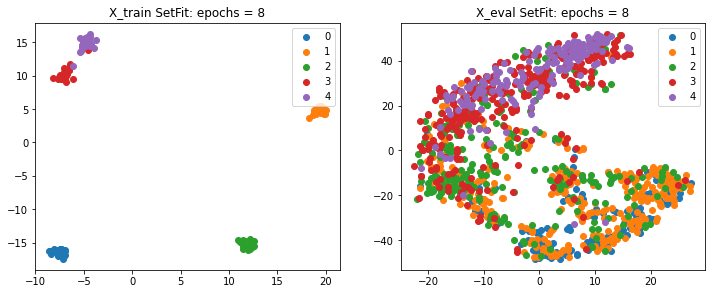

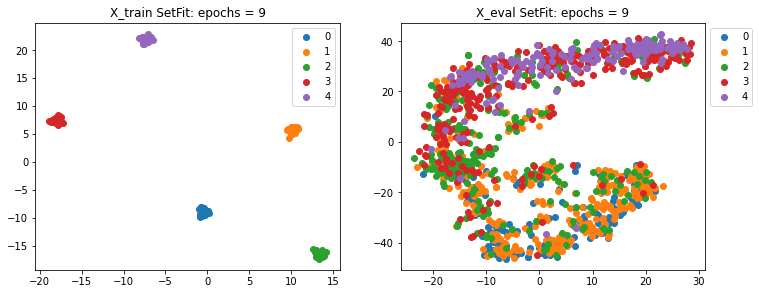

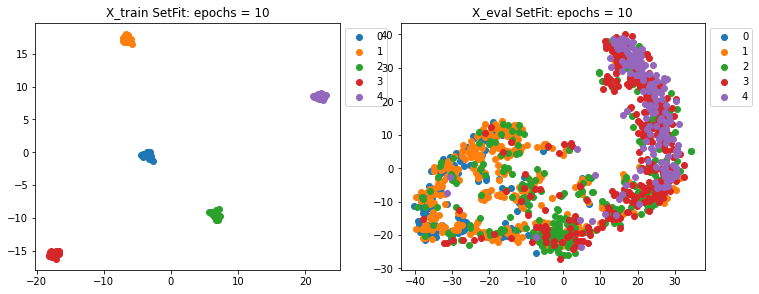

In [18]:
sst5_neg1_accs = []
for epoch in range(LOWER, UPPER):
    acc = SetFit(train_df, eval_df, epoch, neg_lab=-1.0)
    sst5_neg1_accs.append(acc)

In [19]:
print('Mean accuracy for SST2 with negative label = 0: {} \n'.format(np.mean(sst2_0_accs)))
print('Mean accuracy for SST2 with negative label = -1: {} \n'.format(np.mean(sst2_neg1_accs)))
print('Mean accuracy for SST5 with negative label = 0: {} \n'.format(np.mean(sst5_0_accs)))
print('Mean accuracy for SST5 with negative label = -1: {} \n'.format(np.mean(sst5_neg1_accs)))

Mean accuracy for SST2 with negative label = 0: 0.8998352553542011 

Mean accuracy for SST2 with negative label = -1: 0.8825919824272377 

Mean accuracy for SST5 with negative label = 0: 0.47520435967302455 

Mean accuracy for SST5 with negative label = -1: 0.4556766575840145 

